# Looking at location (distance, within TAD) of features (enhancers, chIP peaks) to dysregulated genes

## Plots for DE genes:

* All applied threshold for WT expression (total counts) 
    * Additional distributions of up/down/nonsig genes within these boundaries in **20221029_expression_threshold**
* Cumulative Distance from TSS of genes to features (enhancers or ChIP peaks)
    * Annotated enhancers (from **20221016_dNipBL_proximal_enhancers**)
    * ChiP peak data (**20221108_dNipBL_proximal_proteins**)
* Distribution (count) of features within a TAD 
    * up/down/non-reg genes with some number of enhancers within TAD (**20221016_dNipBL_proximal_enhancers**) 
    * split by basal expression bin (**20221029_expression_threshold**)

In [1]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bioframe as bf
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
import sys
 
# setting path
sys.path.append('../../transcription_data_analysis')

import plotting_histogram_functions as pfn
import filter_gene_functions as flt

# Loading all data

### Project Files, annotating TSSes, merging average vst-normalized feature counts into results table

In [3]:
proj = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"
# Importing day 1 depletion in ESCs DEGS
day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'
vst_normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized_vst-transformed.csv'
WT_samples = ['KHRNA1', 'KHRNA7', 'KHRNA13', 'KHRNA22', 'KHRNA23', 'KHRNA50']

# import results table and add normalized feature counts to label non-significant genes
day1_res_df = pd.read_csv(proj+day1_sigRes)
vst_counts_df = pd.read_csv(proj+vst_normalized_counts).rename(columns={'Unnamed: 0' : 'Geneid'})
vst_counts_df['avg_vst_counts'] = vst_counts_df[WT_samples].mean(axis='columns')
day1_res_df = day1_res_df.merge(vst_counts_df[['Geneid', 'avg_vst_counts']], how='outer')

# Getting TSSEs
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")
ts_intervals = flt.get_tss_gene_intervals(tss_df)

# labelling our dataset
day1_res_df = day1_res_df.merge(ts_intervals, left_on='Geneid', right_on='gene_id', how='left')

# If could not find a TSS, drop entire row
day1_res_df.dropna(subset=['start'], inplace=True)

# Remove any genes mapped to chrX before proceeding --> save these for later analysis
day1_res_df = day1_res_df[~day1_res_df.chrom.isin(['chrX'])]
day1_res_df = bf.sanitize_bedframe(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


### import feature data: enhancer files, ChIP files, insulation boundaries

In [4]:
dataset_folder = '/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/Published_datasets/'

chen_s1 = 'Enhancers_Chen2012_S1_remapped_mm10.bed'
whythe_super = 'Super-enhancers_mESCs_(OSN-MED1)_Wythe-Cell-2023_mm10-lifetover.bed'
# whythe_reg = 'remapped_enhancers_Whyte_2013_mm9.bed.txt' <-- where is this?

enhancers = {'chen_s1' : dataset_folder+chen_s1,
             'wythe_super' : dataset_folder+whythe_super}

In [5]:
# Load Chip-Seq files 
chip_folder = "/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/"

ctcf = "CTCF_peaks_called_on_4reps_foundInatLeast2reps_noBlacklist.bed"
rad21 = "RAD21_peaks_called_on_6reps_foundInatLeast3reps_noBlacklist.bed"
nipbl = "Nipbl_112.175.197.114.177.196_peaks.xls.bed"
promoter = "H3K27ac_EA92-97_peaks.xls.bed"

chip_peaks_condition_dict = {'CTCF' : chip_folder+ctcf, 'RAD21' : chip_folder+rad21,
                           'NIPBL' : chip_folder+nipbl, 'H3K27ac' : chip_folder+promoter}

In [6]:
# load features for boundaries
feature_dir = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features'
insulation_table = pd.read_table(feature_dir+'/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation')

### Annotate Gene Expression Categories, apply threshold and separate dataset into quantiles

In [7]:
# Add the differential expression status for filtering genes
day1_res_df = flt.label_DE_status(day1_res_df)

In [8]:
# set counts threshold to 6.0
cutoff = 6.0
cut = (day1_res_df['avg_vst_counts'] > cutoff)
day1_res_df = day1_res_df[cut]

In [9]:
# Break up the categories into quantiles according ot vst_counts
quantiled_df = day1_res_df.copy()

quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_vst_counts")
quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_vst_counts", label_subset='up')
quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_vst_counts", label_subset='down')

# Cumulative Distance Plots

* Chen/Whyte Enhancers
* All ChIP peaks

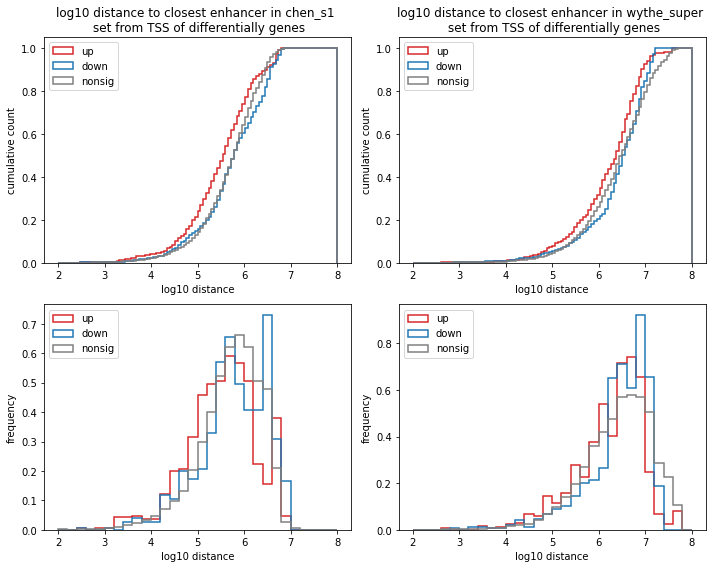

In [10]:
# Label distance to closest enhancer
for label, file in enhancers.items():
    day1_res_df = flt.label_closest_enhancer(day1_res_df, file, label)

# Plot
fig, axs = plt.subplots(2,2, figsize=(10, 8))

for (enhancer_label, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):
    pfn.plot_distance_histogram(day1_res_df, 
                                 enhancer_label+'_distance', 
                                 ax=axs[0, axi],
                                 cumulative=True,
                                 bins=100,
                                 plot_title='log10 distance to closest enhancer in {} \n set from TSS of differentially genes'.format(enhancer_label))
    
    pfn.plot_distance_histogram(day1_res_df, 
                                enhancer_label+'_distance', 
                                ax=axs[1, axi],
                                bins=30)
    
plt.tight_layout()
plt.show()

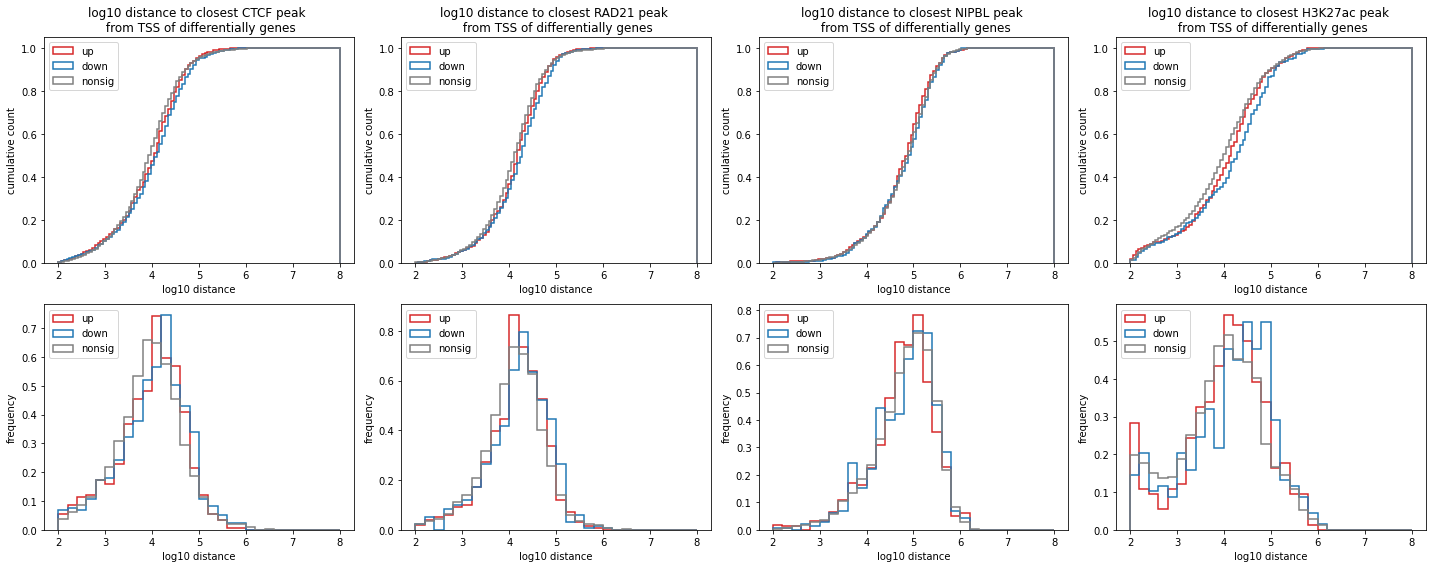

In [11]:
# Annotate df with distance to each peak
for (chip, file) in chip_peaks_condition_dict.items():
    peaks = flt.get_peak_bioframe(file)
    day1_res_df = flt.label_closest_peak(day1_res_df, peaks, chip)
    
fig, axs = plt.subplots(2, len(chip_peaks_condition_dict), figsize=(20, 8))

for (chip_name, file), axi in zip(chip_peaks_condition_dict.items(), np.arange(axs.shape[1])):
    pfn.plot_distance_histogram(day1_res_df, 
                                 chip_name+'_distance', 
                                 ax=axs[0, axi],
                                 cumulative=True,
                                 bins=100,
                                 plot_title='log10 distance to closest {} peak \n from TSS of differentially genes'.format(chip_name))
    
    pfn.plot_distance_histogram(day1_res_df, 
                                chip_name+'_distance', 
                                ax=axs[1, axi],
                                bins=30)
    
plt.tight_layout()
plt.show()

# Distribution of features and DEGs within a TAD

* Chen/Whyte enhancers: basic DE split
* Chen/Whyte enhancers: quantile split

In [12]:
# Defining TADs using midpoints between boundaries
tad_mid_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=True)

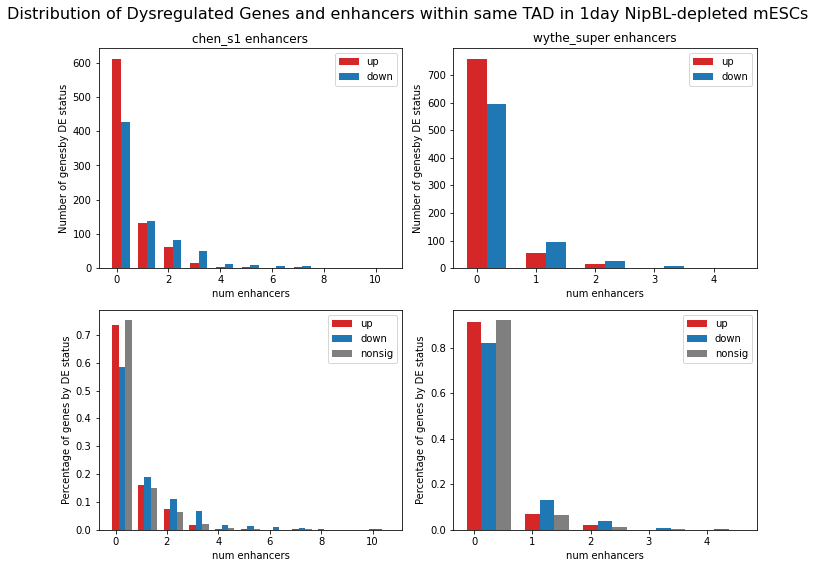

In [13]:
fig, axs = plt.subplots(2,2, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'enhancers within same TAD in 1day NipBL-depleted mESCs'),
             fontsize=16)

for (enh_source, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):

    # Annotate number of enhancers within the tad
    df = tad_mid_df.copy()
    enhancer_df = flt.get_enhancer_bioframe(file)
    df['num_enhancers'] = bf.count_overlaps(df, enhancer_df)['count']
    
    pfn.group_features_by_region(df,
                                 day1_res_df,
                                 feature_category_colors={"up": 'tab:red', 
                                                      "down": 'tab:blue'},
                                 plot_title='{} enhancers'.format(enh_source),
                                 ax=axs[0, axi]
                                )
                                  
    pfn.distribution_features_by_region(df,
                                        day1_res_df,
                                        plot_title='',
                                        ax=axs[1, axi]
                                       )
    
plt.tight_layout()
plt.show()

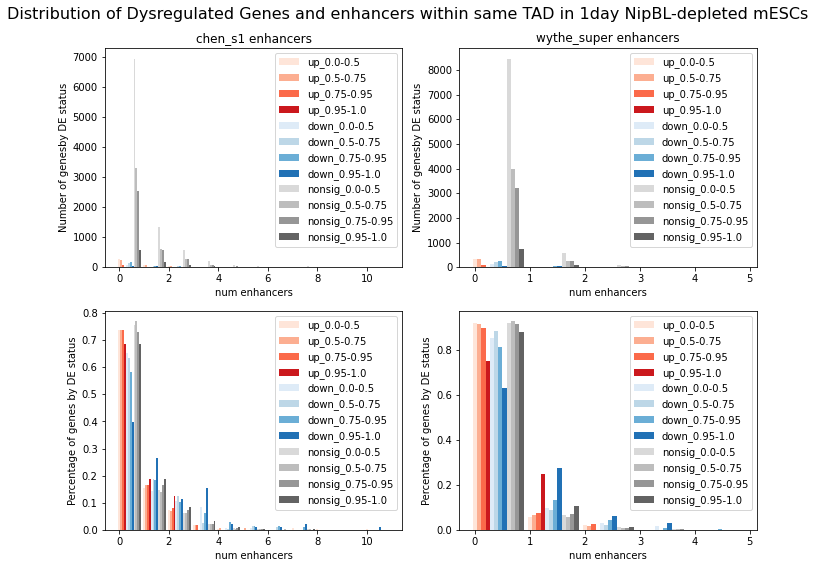

In [14]:
category_colormap_big = {'up_0.0-0.5' : '#fee5d9',
                         'up_0.5-0.75' : '#fcae91',
                         'up_0.75-0.95' : '#fb6a4a',
                         'up_0.95-1.0' : '#cb181d',

                         'down_0.0-0.5' : '#deebf7',
                         'down_0.5-0.75' : '#bdd7e7',
                         'down_0.75-0.95' : '#6baed6',
                         'down_0.95-1.0' : '#2171b5',

                         'nonsig_0.0-0.5' : '#d9d9d9',
                         'nonsig_0.5-0.75' : '#bdbdbd',
                         'nonsig_0.75-0.95' : '#969696',
                         'nonsig_0.95-1.0' : '#636363'
                        }

fig, axs = plt.subplots(2,2, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'enhancers within same TAD in 1day NipBL-depleted mESCs'),
             fontsize=16)

for (enh_source, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):

    # Annotate number of enhancers within the tad
    df = tad_mid_df.copy()
    
    enhancer_df = flt.get_enhancer_bioframe(file)
    df['num_enhancers'] = bf.count_overlaps(df, enhancer_df)['count']
    
    pfn.group_features_by_region(df,
                                 quantiled_df,
                                 feature_category_colors=category_colormap_big,
                                 plot_title='{} enhancers'.format(enh_source),
                                 ax=axs[0, axi]
                                )
                                  
    pfn.distribution_features_by_region(df,
                                        quantiled_df,
                                        plot_title='',
                                        feature_category_colors=category_colormap_big,
                                        ax=axs[1, axi]
                                       )
    
plt.tight_layout()
plt.show()